# Dopolnitev CSV in zapolnjevanje manjkajocih vrednosti

Notebook:
- najprej izpise manjkajoce vrednosti po stolpcih v vhodnih CSV-jih (pred dopolnitvijo)
- dopolni vsako postajo na urni indeks in shrani v `../data/raw`
- zapolni manjkajoce vrednosti po stolpcih z `sklearn.IterativeImputer` (multivariatno)
- ce je stolpec povsem prazen, uporabi fallback 0
- izpise preostale manjkajoce vrednosti po stolpcih (in po postajah)
- shrani en pregleden graf delezov manjkajocih po stolpcih


In [34]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)


In [35]:
def find_project_root(start: Path) -> Path:
    start = start.resolve()
    candidates = [start, *start.parents]
    for c in candidates:
        if (c / "pyproject.toml").exists() and (c / "data").exists():
            return c
    return start

ROOT_DIR = find_project_root(Path.cwd())
INPUT_DIR = ROOT_DIR / "data" / "original"
OUTPUT_DIR = ROOT_DIR / "data" / "raw"
REPORTS_DIR = ROOT_DIR / "reports"
PLOTS_DIR = REPORTS_DIR / "plots"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

files = sorted(INPUT_DIR.glob("*.csv"))
print(f"ROOT_DIR: {ROOT_DIR}")
print(f"INPUT_DIR: {INPUT_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"CSV files found: {len(files)}")
if len(files) == 0:
    raise FileNotFoundError(f"No CSV files found in {INPUT_DIR}")
len(files)


ROOT_DIR: /home/benjamin/priprava_podatkov
INPUT_DIR: /home/benjamin/priprava_podatkov/data/original
OUTPUT_DIR: /home/benjamin/priprava_podatkov/data/raw
CSV files found: 21


21

In [36]:
# Manjkajoce vrednosti po stolpcih v vhodnih CSV-jih (pred dopolnitvijo/imputacijo)
initial_missing_rows = []
for path in files:
    df0 = pd.read_csv(path)
    total_rows = len(df0)
    station = path.stem
    for col in df0.columns:
        if col == "datetime":
            continue
        miss = int(pd.to_numeric(df0[col], errors="coerce").isna().sum())
        initial_missing_rows.append({
            "station": station,
            "column": col,
            "total_rows": total_rows,
            "missing_count": miss
        })

if initial_missing_rows:
    initial_missing_by_station_col = pd.DataFrame(initial_missing_rows).sort_values(["station", "column"]).reset_index(drop=True)
    initial_missing_by_col = initial_missing_by_station_col.groupby("column", as_index=False)[["total_rows", "missing_count"]].sum()
    initial_missing_by_col["missing_pct"] = initial_missing_by_col["missing_count"] / initial_missing_by_col["total_rows"] * 100
    initial_missing_by_col = initial_missing_by_col.sort_values("missing_pct", ascending=False).reset_index(drop=True)
else:
    initial_missing_by_station_col = pd.DataFrame(columns=["station", "column", "total_rows", "missing_count"])
    initial_missing_by_col = pd.DataFrame(columns=["column", "total_rows", "missing_count", "missing_pct"])

initial_missing_by_col


,column,total_rows,missing_count,missing_pct
0,clouds,296100,296100,100.000000
1,wind_direction,296100,296100,100.000000
2,PM10,296100,4902,1.655522
3,PM2.5,296100,4879,1.647754
4,pressure,296100,4866,1.643364
5,precipitation,296100,4551,1.536981
6,rain,296100,4551,1.536981
7,temperature,296100,4551,1.536981
8,wind_speed,296100,4551,1.536981


In [37]:
def complete_station_csv(path: Path):
    station = path.stem
    df = pd.read_csv(path)
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    invalid_datetime = int(df["datetime"].isna().sum())

    df = df.dropna(subset=["datetime"]).sort_values("datetime")
    if df.empty:
        empty = pd.DataFrame(columns=["datetime"] + [c for c in df.columns if c != "datetime"])
        empty.to_csv(OUTPUT_DIR / f"{station}.csv", index=False)
        return {
            "station": station,
            "rows_original": 0,
            "rows_completed": 0,
            "inserted_rows": 0,
            "invalid_datetime": invalid_datetime,
            "imputed_values": 0
        }, empty

    before_rows = len(df)
    df = df.drop_duplicates(subset=["datetime"], keep="last")

    full_index = pd.date_range(df["datetime"].min(), df["datetime"].max(), freq="h")
    completed = df.set_index("datetime").reindex(full_index)
    completed.index.name = "datetime"
    completed = completed.reset_index()

    feature_cols = [c for c in completed.columns if c != "datetime"]
    numeric = completed[feature_cols].apply(pd.to_numeric, errors="coerce")
    before_missing = int(numeric.isna().sum().sum())

    all_missing_cols = [c for c in feature_cols if numeric[c].isna().all()]
    iterative_cols = [c for c in feature_cols if c not in all_missing_cols]

    if iterative_cols and numeric[iterative_cols].isna().any().any():
        imputer = IterativeImputer(
            max_iter=20,
            random_state=42,
            initial_strategy="median",
            skip_complete=True,
        )
        numeric.loc[:, iterative_cols] = imputer.fit_transform(numeric[iterative_cols])

    for col in all_missing_cols:
        numeric[col] = 0.0

    completed[feature_cols] = numeric
    after_missing = int(completed[feature_cols].isna().sum().sum())
    imputed_values = before_missing - after_missing

    completed.to_csv(OUTPUT_DIR / f"{station}.csv", index=False)

    return {
        "station": station,
        "rows_original": before_rows,
        "rows_completed": len(completed),
        "inserted_rows": int(len(completed) - len(df)),
        "invalid_datetime": invalid_datetime,
        "imputed_values": imputed_values
    }, completed


In [ ]:
meta_rows = []
completed_frames = {}
errors = []

for path in files:
    try:
        meta, completed = complete_station_csv(path)
        if isinstance(meta, dict):
            meta_rows.append(meta)
            station_name = meta.get("station")
            if station_name is not None:
                completed_frames[station_name] = completed
            else:
                errors.append({"file": path.name, "error": "Missing 'station' in metadata"})
        else:
            errors.append({"file": path.name, "error": "Metadata is not a dict"})
    except Exception as e:
        errors.append({"file": path.name, "error": str(e)})

completion_summary = pd.DataFrame(meta_rows)
if not completion_summary.empty and "station" in completion_summary.columns:
    completion_summary = completion_summary.sort_values("station").reset_index(drop=True)

if errors:
    print(f"Napake pri obdelavi: {len(errors)}")
    print(pd.DataFrame(errors).head(20))

print(completion_summary)

print(f"Skupaj uspesno obdelanih postaj: {len(completion_summary)}")
print(f"Izhodne datoteke v OUTPUT_DIR: {len(list(OUTPUT_DIR.glob('*.csv')))}")


/home/benjamin/miniconda3/envs/ml-pytorch/lib/python3.11/site-packages/sklearn/impute/_iterative.py:867: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Skupaj uspesno obdelanih postaj: 21
Izhodne datoteke v OUTPUT_DIR: 21


In [39]:
missing_rows = []
for station, cdf in completed_frames.items():
    total_rows = len(cdf)
    for col in cdf.columns:
        if col == "datetime":
            continue
        missing_count = int(cdf[col].isna().sum())
        missing_rows.append({
            "station": station,
            "column": col,
            "total_rows": total_rows,
            "missing_count": missing_count,
            "missing_pct": (missing_count / total_rows * 100) if total_rows else 0.0
        })

if missing_rows:
    missing_by_station_col = pd.DataFrame(missing_rows).sort_values(["station", "column"]).reset_index(drop=True)
    missing_by_col = missing_by_station_col.groupby("column", as_index=False)[["total_rows", "missing_count"]].sum()
    missing_by_col["missing_pct"] = missing_by_col["missing_count"] / missing_by_col["total_rows"] * 100
    missing_by_col = missing_by_col.sort_values("missing_pct", ascending=False).reset_index(drop=True)
else:
    missing_by_station_col = pd.DataFrame(columns=["station", "column", "total_rows", "missing_count", "missing_pct"])
    missing_by_col = pd.DataFrame(columns=["column", "total_rows", "missing_count", "missing_pct"])
    print("Ni podatkov za izracun manjkajocih vrednosti; preveri zgornje napake.")

missing_by_col


,column,total_rows,missing_count,missing_pct
0,PM10,296100,0,0.0
1,PM2.5,296100,0,0.0
2,clouds,296100,0,0.0
3,precipitation,296100,0,0.0
4,pressure,296100,0,0.0
5,rain,296100,0,0.0
6,temperature,296100,0,0.0
7,wind_direction,296100,0,0.0
8,wind_speed,296100,0,0.0


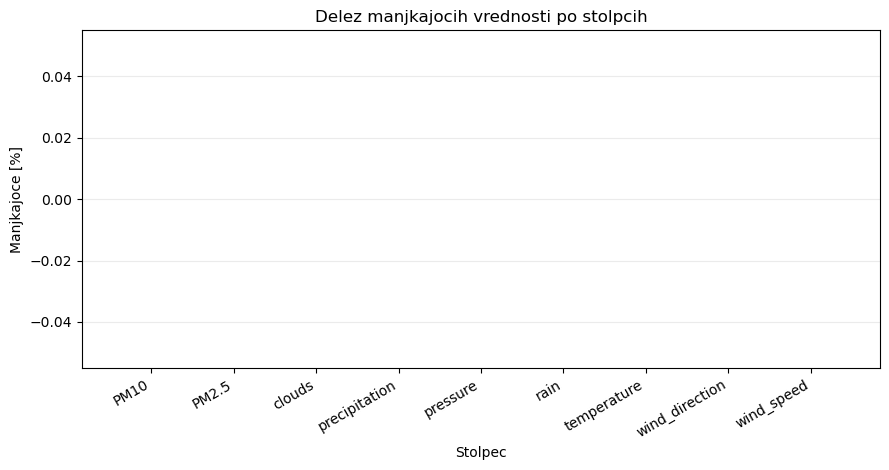

In [40]:
# Pregleden graf: delez manjkajocih po stolpcih
fig, ax = plt.subplots(figsize=(9, 4.8))
ax.bar(missing_by_col["column"], missing_by_col["missing_pct"], color="#2a9d8f")
ax.set_title("Delez manjkajocih vrednosti po stolpcih")
ax.set_xlabel("Stolpec")
ax.set_ylabel("Manjkajoce [%]")
ax.grid(axis="y", alpha=0.25)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
fig.savefig(PLOTS_DIR / "missing_pct_by_column.png", dpi=160)
plt.show()

In [41]:
completion_summary.to_csv(REPORTS_DIR / "completion_inserted_rows_summary.csv", index=False)
missing_by_station_col.to_csv(REPORTS_DIR / "missing_by_station_column.csv", index=False)
missing_by_col.to_csv(REPORTS_DIR / "missing_by_column_overall.csv", index=False)

print("Shranjeno:")
print(OUTPUT_DIR)
print(REPORTS_DIR / "completion_inserted_rows_summary.csv")
print(REPORTS_DIR / "missing_by_station_column.csv")
print(REPORTS_DIR / "missing_by_column_overall.csv")
print(PLOTS_DIR / "missing_pct_by_column.png")


Shranjeno:
/home/benjamin/priprava_podatkov/data/raw
/home/benjamin/priprava_podatkov/reports/completion_inserted_rows_summary.csv
/home/benjamin/priprava_podatkov/reports/missing_by_station_column.csv
/home/benjamin/priprava_podatkov/reports/missing_by_column_overall.csv
/home/benjamin/priprava_podatkov/reports/plots/missing_pct_by_column.png
